In [1]:
%matplotlib inline


from __future__ import division

import numpy as np
import scipy
import time, re, os, sys
import copy as cp

import matplotlib.pyplot as plt
import seaborn
from scipy.stats import multivariate_normal
import scipy.spatial.distance as dst
seaborn.set_context("paper",font_scale=2)
seaborn.set_style("whitegrid")


kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)
matern23 = lambda x1,x2: (1 + np.sqrt(3)*(x2-x1)/l)*np.exp(-(np.sqrt(3)*(x2-x1)/l))

In [2]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='euclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        #print 'here'
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='euclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [3]:
def matern3on2(x_p, x_q, LS):
    # The Matern 3/2 kernel is often used as a less smooth alternative to the
    # gaussian kernel for natural data.
    x_p = np.vstack([x_p,np.zeros(x_p.shape)]).T
    x_q = np.vstack([x_q,np.zeros(x_q.shape)]).T
    if x_q is None:
        return np.ones(x_p.shape[0])

    r = dst.cdist(x_p/LS, x_q/LS, 'euclidean')
    value = (1.0 + r)*np.exp(-r)
    return value

In [4]:
def matern52(theta, d):
    """
    Matern 5/2 correlation model.::"""
    
    
    theta = np.asarray(theta, dtype=np.float)
    d = np.asarray(d, dtype=np.float)
    
    if d.ndim > 1:
        n_features = d.shape[1]
    else:
        n_features = 1
        
    if theta.size == 1:
        r = np.sqrt(d ** 2) / theta
    elif theta.size != n_features:
        raise ValueError("Length of theta must be 1 or %s" % n_features)
    else:
        r = np.sqrt(np.sum(d ** 2 / theta.reshape(1,n_features) ** 2 , axis=1))
        
    return (1 + np.sqrt(5)*r + 5/3.*r ** 2) * np.exp(-np.sqrt(5)*r)

In [111]:
def get_covariance_matrix(x,y=None,k=3,l=.5,add_offset=1e-6,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    #cov = k*np.exp(-.5*distsSq/(2*l**2)) 
    cov = matern52(l,distsSq)
    #cov = k*(1 + np.sqrt(3)*((distsSq)/l))*np.exp(-(np.sqrt(3)*(distsSq/l)))  #matern 3/2
    #cov = k*(1 + np.sqrt(5)*distsSq/l + 5**(distsSq**2)/(3*l**2))*np.exp(-(np.sqrt(5)*distsSq)/l)  #matern 5/2

    #d_idxs = np.diag_indices_from(cov)
    #cov[d_idxs] += 1e-6#add_offset
    cov /= np.max(cov)
    return cov

# Generate Data

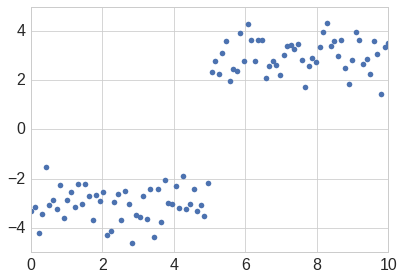

In [112]:
#D = np.array([[3,.1],[4,.1],[5,.1],[40,2],[80,-4]])
xs = np.linspace(0.01,10,num=100)
n_samps = len(xs)
#ys = np.sin(.5*np.pi*xs)*3 + np.sin(2*np.pi*xs) #+ (1/np.exp(xs/2))*6*np.sin(1*np.pi*xs) #+ xs//2
#ys = (1/np.exp(xs/2))*4*np.sin(2*np.pi*xs) + xs/2
ys = np.hstack([np.zeros(50),np.ones(50)*6]) - 3 + np.random.normal(scale=.7,size=n_samps)


plt.plot(xs,ys,'o')

D = np.vstack([xs,ys]).T

#plt.plot(xs,D[:,1],'o')

n_samps = 220
x_samples = np.linspace(0,10,num=n_samps)

In [113]:
#define parameters for the GP regression
k = 1e0
l = 1e-1

In [114]:
K = get_covariance_matrix(D[:,0],k=k,l=l,add_offset=0)#np.zeros([D.shape[0],D.shape[0]])
K += 2*np.eye(D.shape[0])   #add the noise term

#this is K* is common notation. Covariance between unseen and seen data points
Kst = get_covariance_matrix(x=x_samples,y=D[:,0],k=k,l=l,add_offset=0)  

#This is K** covariance matrix just between unseen and unseen x-values
Kstst = get_covariance_matrix(x=x_samples,k=k,l=l,add_offset=0)


## Specify Prior and Infer Posterior Distribution

In [115]:
GP_prior = multivariate_normal(np.zeros(n_samps),cov=Kstst + np.eye(n_samps)*1e-6)

In [116]:
GP_mean = Kst.dot(np.linalg.inv(K)).dot(D[:,1])

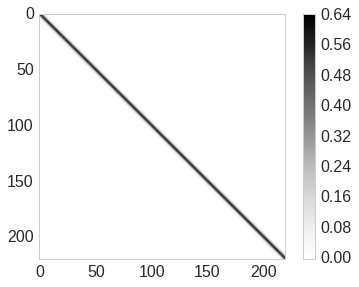

In [117]:
GP_cov = (Kstst - Kst.dot(np.linalg.inv(K)).dot(Kst.T)) + np.eye(GP_mean.shape[0])*1e-6


plt.imshow(GP_cov)
plt.grid()
plt.colorbar()

In [118]:

GP_posterior = multivariate_normal(GP_mean,GP_cov)

#  This is success enjoy the beautiful plot of samples from the posterior

(0, 6.3)

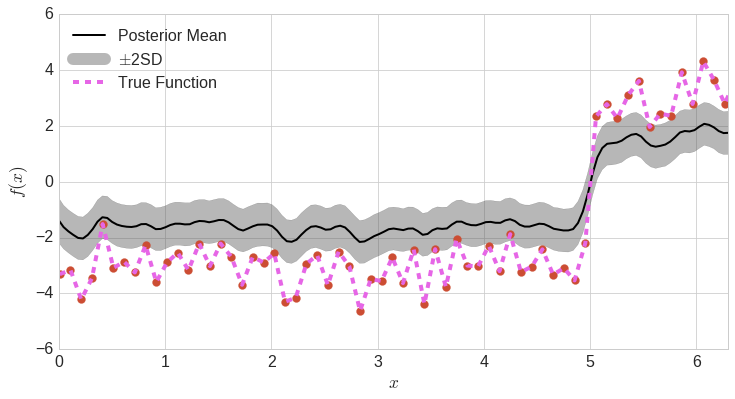

In [119]:
plt.figure(figsize=(12,6))

ax = plt.gca()

#for i in range(4):
#    ax.plot(x_samples,GP_posterior.rvs())
    
#ax.plot(x_samples,GP_posterior.rvs(),label='Posterior Samples')


ax.plot(x_samples,GP_mean,linewidth=2,color='k',label='Posterior Mean')



ax.fill_between(x_samples, GP_mean-np.sqrt(np.diag(GP_cov)), GP_mean+np.sqrt(np.diag(GP_cov)), facecolor=[.3]*3,alpha=.4, interpolate=True)
ax.plot([0], [0], color=[.3]*3,alpha=.4,linewidth=12, label='$\pm$2SD')


ax.plot(D[:,0],ys,color=[.9,.4,.9],linestyle='--',linewidth=4,label='True Function')
ax.scatter(D[:,0],D[:,1],s=64,color=[.8,.3,.2])

ax.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.xlim(xmin=0,xmax=6.3)

(0, 6.3)

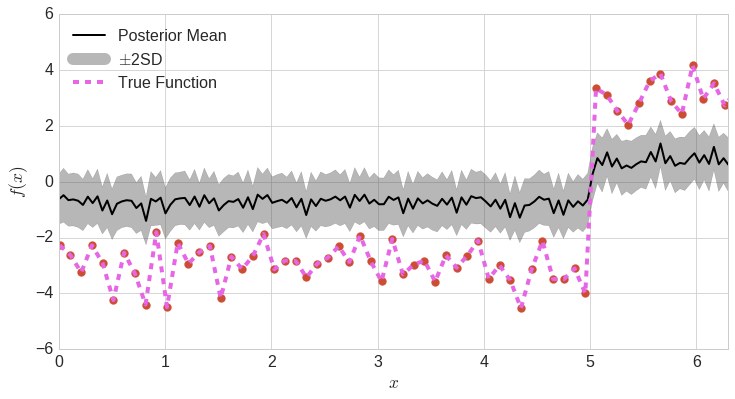

In [110]:
plt.figure(figsize=(12,6))

ax = plt.gca()

#for i in range(4):
#    ax.plot(x_samples,GP_posterior.rvs())
    
#ax.plot(x_samples,GP_posterior.rvs(),label='Posterior Samples')


ax.plot(x_samples,GP_mean,linewidth=2,color='k',label='Posterior Mean')



ax.fill_between(x_samples, GP_mean-np.sqrt(np.diag(GP_cov)), GP_mean+np.sqrt(np.diag(GP_cov)), facecolor=[.3]*3,alpha=.4, interpolate=True)
ax.plot([0], [0], color=[.3]*3,alpha=.4,linewidth=12, label='$\pm$2SD')


ax.plot(D[:,0],ys,color=[.9,.4,.9],linestyle='--',linewidth=4,label='True Function')
ax.scatter(D[:,0],D[:,1],s=64,color=[.8,.3,.2])

ax.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.xlim(xmin=0,xmax=6.3)

## Trying to Optimise the Timescale hyperparameter

### Eqns for timescale opt



$lnP(y|x, \theta) = -\frac{1}{2}ln|K| - \frac{1}{2}y^tK^{-1}y - \frac{N}{2}ln{2\pi}$


$\frac{\partial}{\partial\theta_i}lnP(y|x, \theta) = -\frac{1}{2}\Big(Tr\big(K^{-1}\frac{\partial K}{\partial\theta_i}\big) + y^TK^{-1}\frac{\partial K}{\partial\theta_i}K^{-1}y^T \Big)$


$K(x,x') = \sigma^2\exp\big(\frac{-(x-x')^T(x-x')}{2l^2}\big)$

$\frac{\partial K}{\partial l} = \sigma^2\exp\big(\frac{-(x-x')^T(x-x')}{2l^2}\big) \frac{(x-x')^T(x-x')}{l^3}.$


In [41]:
L = np.linalg.cholesky(K+np.eye(K.shape[0])*1e-3)
beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,ys))
np.sum(np.log(np.diag(L)))
#logp = -0.5*np.dot(t.transpose(),beta) - np.sum(np.log(np.diag(L))) - \
#       np.shape(data)[0] /2. * np.log(2*np.pi)
np.dot(ys.transpose(),beta)

70.330928341869594

In [901]:
ys.dot(np.dot(np.linalg.inv(K),ys))

3703035774997632.0

In [917]:
def logPosterior(tav,x,t):
    #data,t = args
    #tav = np.exp(tav)
    #print np.allclose(x,xs)
    K = get_covariance_matrix(x,k=k,l=tav,add_offset=0)
    L = np.linalg.cholesky(K+1e-3*np.eye(K.shape[0]))
    beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,t))
    t1 = np.dot(t.transpose(),beta)
    #print t1
    #print 2*np.sum(np.log(np.diag(L)))
    #print np.shape(x)[0] * np.log(2*np.pi)
    logp = -0.5*np.dot(t.transpose(),beta) - np.sum(np.log(np.diag(L))) - \
           np.shape(x)[0] /2. * np.log(2*np.pi)
    return -logp

In [961]:
logPosterior(2,xs,ys)

71961.813818539085

In [919]:
K=get_covariance_matrix(xs,k=k,l=2,add_offset=0)

In [920]:
np.dot(ys,np.dot(np.linalg.inv(K)+1e-3*np.eye(K.shape[0]),ys))

3703035774997632.0

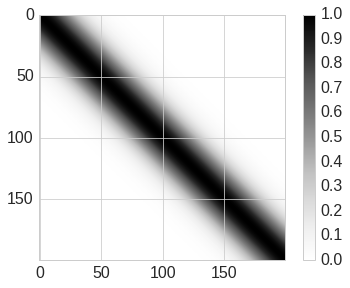

In [1006]:
ccc,_ = calc_K(xs,l=1e0)
plt.imshow(ccc)
plt.colorbar()

In [996]:
logPost(3,x=xs,y=ys)

-252.16826869357661

In [983]:
def calc_K(x,l,k=1e-3):
    
    a1,a2 = np.meshgrid(x,x)
    sqDist = (a1-a2)**2
    cov = (1-k)*np.exp(-.5*sqDist*l) + np.eye(len(x))*k
    return cov,sqDist

In [984]:
def logPost(tav,x,y):
    
    tav = np.exp(tav)
    #tav = np.log(tav)
    #K=get_covariance_matrix(x,k=k,l=tav,add_offset=0)
    K,sqDist = calc_K(x,l=tav)
    #K += 1e-3*np.eye(K.shape[0])

    s,logdet = np.linalg.slogdet(K)
    t1 = s*logdet 
    Kinv = np.linalg.inv(K)
    t2 = y.dot(np.dot(Kinv,y))

    t3 = len(y)*np.log(2*np.pi)
    ll = -.5*(t1 + t2 + t3)
    return -ll

In [985]:
def logPost_grad(tav,x,y):
    
    tav = np.exp(tav)
    #print tav
    #Km=get_covariance_matrix(t,k=k,l=tav,add_offset=0)
    K,sqDist = calc_K(x,l=tav)
        
    Kinv = np.linalg.inv(K)
    dK = sqDist*K
    t1 = np.trace(np.dot(Kinv,dK))
    
    t2 = np.dot(np.dot(y,Kinv),
                np.dot(dK,Kinv).dot(y))

    dl = -.5*(t1 + t2)
    
    return dl

In [1013]:
initp =100
import scipy.optimize as op
r = op.minimize(fun = logPosterior,
                x0 = initp,
                args = (xs,ys),
                jac=0,
                method='CG',
                options = {'disp': True,'gtol':1e-4,})
                #pOptimizeDetails[xd] = res
                #tempTau[xd] = (1/np.exp(res.x))**(0.5)""")

         Current function value: -303.811227
         Iterations: 2
         Function evaluations: 51
         Gradient evaluations: 13


In [1014]:
r

     fun: -303.8112271239296
     jac: array([-1.1556778])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 51
     nit: 2
    njev: 13
  status: 2
 success: False
       x: array([ 0.24728849])

## Samples From Posterior Distribution of Functions

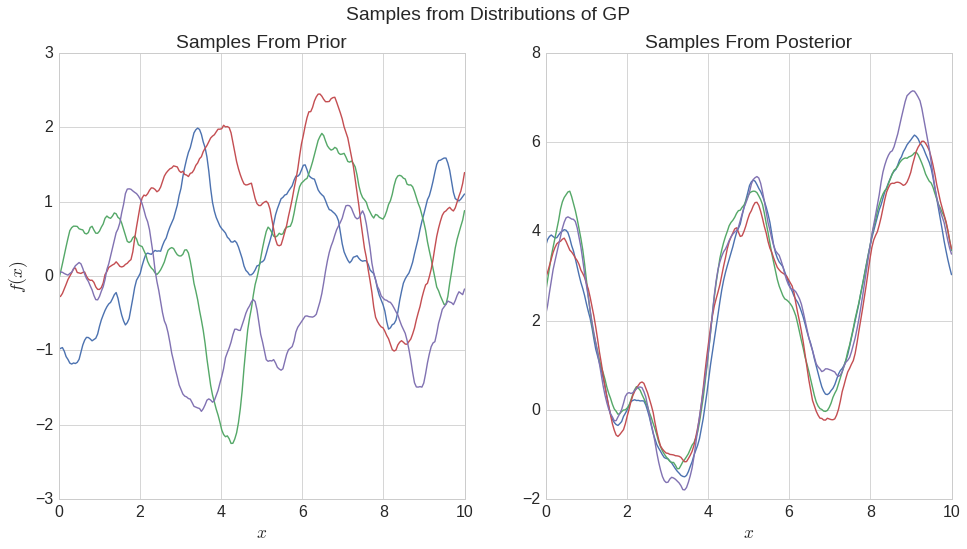

In [300]:
plt.figure(figsize=(16,8))
plt.suptitle('Samples from Distributions of GP \n\n')

plt.subplot(1,2,1)
plt.title('Samples From Prior')
ax = plt.gca()
for i in range(3):
    ax.plot(x_samples,GP_prior.rvs())
    
ax.plot(x_samples,GP_prior.rvs(),label='Samples')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')


plt.subplot(1,2,2)
ax = plt.gca()
plt.title('\nSamples From Posterior')
for i in range(3):
    ax.plot(x_samples,GP_posterior.rvs())
    
ax.plot(x_samples,GP_posterior.rvs(),label='Samples')
plt.xlabel(r'$x$')




# Repeat Procedure in 2D

In [301]:
n_samps = 40
x_pos = np.linspace(1,5,num=n_samps)
y_pos = np.linspace(3,5,num=n_samps)
xy_pos = np.vstack([x_pos,y_pos])

In [94]:
a,b = np.meshgrid(x_pos,y_pos)

gridspec = a.shape
a = a.flatten()
b = b.flatten()

In [95]:
xy_pos = np.vstack([a.flatten(),b.flatten()])

In [96]:
l = 1.
k = 10

In [97]:
Kstst = get_covariance_matrix(x=xy_pos.T,k=k,l=l,add_offset=0) + np.eye(n_samps**2)*1e-6


In [98]:
sample = np.random.multivariate_normal(mean=np.zeros(Kstst.shape[0]),cov=Kstst)

In [99]:
GP_prior = multivariate_normal(cov=Kstst)

In [100]:
sample = GP_prior.rvs()

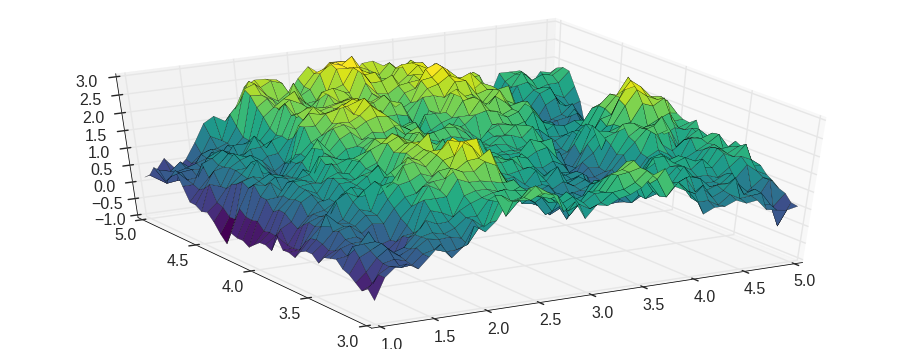

In [101]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,6))
plt.title('Target Surface')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a.reshape(gridspec),b.reshape(gridspec),sample.reshape(n_samps,n_samps),rstride=1, cstride=1,cmap=matplotlib.cm.viridis,)
ax.view_init(elev=40,azim=-120)

In [35]:
k = 5

In [36]:
num_sel = 5

In [37]:
K = get_covariance_matrix(x=xy_pos[:,::num_sel].T,k=k,l=l,add_offset=0)

#dummy = np.arange(xy_pos.shape[1])[::4]
#idxs = np.setdiff1d(np.arange(xy_pos.shape[1]),dummy)

K += 2*np.eye(K.shape[0])   #add the noise term

$\mathbf{A}^{-1} = (\mathbf{L}^{-1})^T(\mathbf{L}^{-1}) = (\mathbf{U}^{-1})(\mathbf{U}^{-1})^T $ 

In [38]:
st = time.time()
U = scipy.linalg.inv(scipy.linalg.cholesky(Kstst,lower=False))
new = U.dot(U.T)
print time.time() - st


0.171759128571


In [39]:
st = time.time()
kk = scipy.linalg.inv(Kstst,check_finite=False)
print time.time() - st
#prev 44...

0.116312026978


In [40]:
Kst = get_covariance_matrix(x=.1+xy_pos.T,
                            y=xy_pos[:,::num_sel].T,
                            k=k,l=l,add_offset=0)  

In [41]:
Kstst = get_covariance_matrix(x=.1+xy_pos.T,
                              k=k,l=l,add_offset=0)


In [42]:
GP_mean = Kst.dot(scipy.linalg.inv(K)).dot(sample[::num_sel])


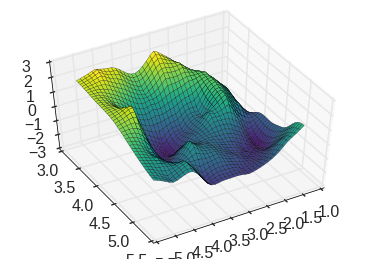

In [43]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a.reshape(gridspec)+.1,b.reshape(gridspec)+.1,GP_mean.reshape(gridspec),
                rstride=1, cstride=1,cmap=matplotlib.cm.viridis,)
ax.view_init(elev=50,azim=60)

 Fraction of data used: 20.0% 
 Total number of datapoints used: 320.0


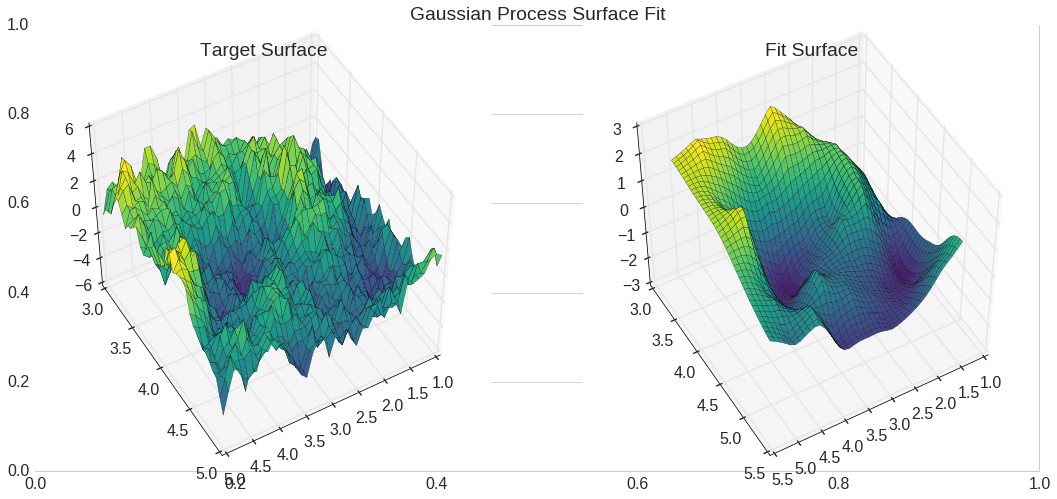

In [44]:
fig = plt.figure(figsize=(18,8))
plt.title('Gaussian Process Surface Fit')

ax = fig.add_subplot(121, projection='3d')
plt.title('Target Surface')

ax.plot_surface(a.reshape(gridspec),b.reshape(gridspec),sample.reshape(n_samps,n_samps),rstride=1, cstride=1,cmap=matplotlib.cm.viridis,)
ax.view_init(elev=50,azim=60)

ax = fig.add_subplot(122, projection='3d')
plt.title('Fit Surface')
ax.plot_surface(a.reshape(gridspec)+.1,b.reshape(gridspec)+.1,GP_mean.reshape(gridspec),
                rstride=1, cstride=1,cmap=matplotlib.cm.viridis)
ax.view_init(elev=50,azim=60)

print ' Fraction of data used: %s%% \n Total number of datapoints used: %s' %(1/num_sel*100,np.round(a.shape[0]*1/num_sel))